1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки


In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from keras.datasets import cifar10
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
def build_net(X_train,
              X_test,
              y_train,
              n_neurons: int=512,
              n_filters: int=64,
              n_layers: int=4,
              n_epochs: int=50,
              kernel_size: int=3,
              dropout: float=0.25, 
              cnn: bool=True,
             ):
    
    model = Sequential()
    tf.random.set_seed(42)
    
    if cnn:
        model.add(Conv2D(n_filters,
                         (kernel_size, kernel_size),
                         padding='same', 
                         input_shape=X_train.shape[1:],
                         activation='relu'
                        )
                 )
        dif_ks = kernel_size // n_layers
        new_kernel_size = kernel_size
        
        for layer in range(1, n_layers):
            
            new_kernel_size -= dif_ks 
            
            model.add(Conv2D(n_filters,
                             (new_kernel_size, new_kernel_size),
                             padding='same', 
                             input_shape=X_train.shape[1:],
                             activation='relu'
                            )
                     )
            if (layer % 2 == 0) and dropout:
                model.add(Dropout(dropout))
                
                model.add(MaxPooling2D(pool_size=(2, 2)))
            
        model.add(Flatten())
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(y_train.shape[1], activation='softmax'))
        
        
        
    else:
        model.add(Flatten(input_shape=X_train.shape[1:]))
        model.add(Dense(n_neurons,
                        activation='sigmoid'
                       )
                 )
        
        dif_n = n_neurons // n_layers
        next_n = n_neurons
        
        for layer in range(1, n_layers):
            next_n -= dif_n 
            model.add(Dense(next_n,
                            activation='relu'
                           )
                     )
            if dropout and (layer % 2 == 0):
                model.add(Dropout(dropout))
        
            
        model.add(Dense(y_train.shape[1], activation='softmax'))     
        
    
    with tf.device("GPU:0"):
        model.compile(loss='categorical_crossentropy',
                      optimizer='SGD',
                      metrics=['accuracy']
                     )
        train = model.fit(X_train,
                          y_train,
                          epochs=n_epochs,
                          verbose=0,
                         )
        result = model.predict(X_test)
    return [model, train, result]

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label is "deer"


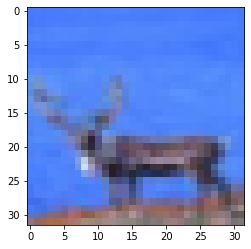

In [6]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is "{classes[y_train[ind][0]]}"')

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [9]:
y_train = to_categorical(y_train, len(classes))
y_test = to_categorical(y_test, len(classes))

y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [10]:
res = build_net(X_train, X_test, y_train, dropout=0.25)

In [11]:
compare = pd.DataFrame(columns=['num_filters', 'num_layers', 'train_acc', 'test_acc'])

In [12]:
compare = compare.append({'num_filters': 32,
                          'num_layers': len(res[0].layers),
                          'train_acc': res[1].history['accuracy'][-1],
                          'test_acc': accuracy_score(y_test.argmax(axis=1), res[2].argmax(axis=1)),
                         }, ignore_index=True)
compare

,num_filters,num_layers,train_acc,test_acc
0,32.0,9.0,0.9166,0.7938


In [13]:
for filters in range(65, 136, 35):
    res = build_net(X_train,
                    X_test,
                    y_train, 
                    n_filters=filters,
                    dropout=0.25
                   )
    compare = compare.append({'num_filters': filters,
                              'num_layers': len(res[0].layers),
                              'train_acc': res[1].history['accuracy'][-1],
                              'test_acc': accuracy_score(y_test.argmax(axis=1), res[2].argmax(axis=1)),
                             }, ignore_index=True)
compare

,num_filters,num_layers,train_acc,test_acc
0,32.0,9.0,0.9166,0.7938
1,65.0,12.0,0.91462,0.7926
2,100.0,12.0,0.94742,0.8
3,135.0,12.0,0.96232,0.7989


Вывод: если увеличивать количество фильтров, то ощутимо растет метрика точности предсказаний на тренировочном датасете, при этом практически не меняется на тестовом. Очевидно, что слепое увеличение фильтров способствует переобучению сети.

In [14]:
for layer in range(4, 7, 1):
    res = build_net(X_train,
                    X_test,
                    y_train, 
                    n_layers=layer,
                    dropout=0.25
                   )
    compare = compare.append({'num_filters': 32,
                              'num_layers': len(res[0].layers),
                              'train_acc': res[1].history['accuracy'][-1],
                              'test_acc': accuracy_score(y_test.argmax(axis=1), res[2].argmax(axis=1)),
                             }, ignore_index=True)
compare

,num_filters,num_layers,train_acc,test_acc
0,32.0,9.0,0.9166,0.7938
1,65.0,12.0,0.91462,0.7926
2,100.0,12.0,0.94742,0.8
3,135.0,12.0,0.96232,0.7989
4,32.0,12.0,0.91484,0.7912
5,32.0,15.0,0.88166,0.7988
6,32.0,17.0,0.8854,0.775


Вывод: увеличение количества слоев привело к минимизации разницы в метриках на тренировочном и тестовом датасетах. Вероятно, что совместно с увеличением количества фильтров возможно будет поднять метрику в-целом.

In [17]:
res = build_net(X_train, X_test, y_train, dropout=0.25, cnn=False)

In [18]:
compare = compare.append({'num_filters': 'dense_model',
                          'num_layers': len(res[0].layers),
                          'train_acc': res[1].history['accuracy'][-1],
                          'test_acc': accuracy_score(y_test.argmax(axis=1), res[2].argmax(axis=1)),
                         }, ignore_index=True)
compare

,num_filters,num_layers,train_acc,test_acc
0,32.0,9.0,0.9166,0.7938
1,65.0,12.0,0.91462,0.7926
2,100.0,12.0,0.94742,0.8
3,135.0,12.0,0.96232,0.7989
4,32.0,12.0,0.91484,0.7912
5,32.0,15.0,0.88166,0.7988
6,32.0,17.0,0.8854,0.775
7,dense_model,7,0.6094,0.5479


Вывод: обычная полносвязная сеть справляется намного хуже с поставленной задачей. Попробуем подобрать параметры для сверточной сети и посмотреть результат. Будем увеличивать поличество фильтров и слоев. Дропаут увеличим до 0.5.

In [35]:
final_try = build_net(X_train,
                      X_test,
                      y_train,
                      n_filters=150,
                      n_layers=10,
                      n_epochs=50, 
                      dropout=0.5
                     )
compare = compare.append({'num_filters': 150,
                          'num_layers': 10,
                          'train_acc': final_try[1].history['accuracy'][-1],
                          'test_acc': accuracy_score(y_test.argmax(axis=1), final_try[2].argmax(axis=1)),
                         }, ignore_index=True)
compare

,num_filters,num_layers,train_acc,test_acc
0,32.0,9.0,0.9166,0.7938
1,65.0,12.0,0.91462,0.7926
2,100.0,12.0,0.94742,0.8
3,135.0,12.0,0.96232,0.7989
4,32.0,12.0,0.91484,0.7912
5,32.0,15.0,0.88166,0.7988
6,32.0,17.0,0.8854,0.775
7,dense_model,7,0.6094,0.5479
8,150.0,10.0,0.93878,0.7689


Получилось даже хуже, к сожалению.